MLP 

In [2]:
pip install pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

In [6]:
df = pd.read_csv("../../Data/social_media_viral_content_dataset.csv")
df.head()


,post_id,platform,content_type,topic,language,region,post_datetime,hashtags,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral
0,SM_100000,Instagram,text,Sports,ur,UK,2024-12-10 00:00:00,#tech #funny #music,2319102,122058,15800,861,0.0598,0.464,1
1,SM_100001,Instagram,carousel,Sports,ur,Brazil,2024-10-13 00:00:00,#news #fyp #funny #ai #trending,2538464,110368,11289,54887,0.0695,-0.800,1
2,SM_100002,YouTube Shorts,video,Technology,ur,UK,2024-05-03 00:00:00,#ai #news,1051176,87598,47196,44132,0.1702,0.416,0
3,SM_100003,X,text,Politics,ur,US,2024-08-04 00:00:00,#ai #funny,5271440,329465,774,59736,0.0740,0.877,1
4,SM_100004,YouTube Shorts,text,Education,es,US,2024-03-28 00:00:00,#news #ai #viral #funny #fyp,3186256,199141,5316,83105,0.0903,0.223,1


In [7]:
def add_time_features(X):
    X = X.copy()
    dt = pd.to_datetime(X["post_datetime"], errors="coerce")
    X["hour"] = dt.dt.hour
    X["dayofweek"] = dt.dt.dayofweek
    X["month"] = dt.dt.month
    X["is_weekend"] = (X["dayofweek"] >= 5).astype(int)
    return X.drop(columns=["post_datetime"])

def add_hashtag_features(X):
    X = X.copy()
    h = X["hashtags"].fillna("").astype(str)

    X["num_hashtags"] = h.apply(lambda s: len([t for t in s.split() if t.startswith("#")]))
    X["has_trending"] = h.str.lower().str.contains(
        "trending|viral|fyp|explore|pourtoi"
    ).astype(int)
    X["hashtags_len"] = h.str.len()
    return X


In [8]:
target = "is_viral"
drop_cols = ["post_id"]

df_feat = add_time_features(df)
df_feat = add_hashtag_features(df_feat)

X = df_feat.drop(columns=[target] + drop_cols)
y = df_feat[target]

print(X.shape)
print(y.value_counts(normalize=True))


(2000, 19)
is_viral
1    0.699
0    0.301
Name: proportion, dtype: float64


In [ ]:
cat_cols = ["platform", "content_type", "topic", "language", "region"]

num_cols = [
    "views", "likes", "comments", "shares", "engagement_rate",
    "sentiment_score",
    "hour", "dayofweek", "month", "is_weekend",
    "num_hashtags", "has_trending", "hashtags_len"
]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)


In [10]:
hidden_layer_configs = [
    (32,),
    (64,),
    (128,),
    (64, 32),
    (128, 64)
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mean_f1_scores = []

for layers in hidden_layer_configs:
    mlp_pipeline = Pipeline(steps=[
        ("prep", preprocess),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=layers,
            activation="relu",
            solver="adam",
            max_iter=300,
            random_state=42,
            early_stopping=True
        ))
    ])
    
    scores = cross_validate(
        mlp_pipeline,
        X, y,
        cv=skf,
        scoring="f1",
        n_jobs=-1
    )
    
    mean_f1_scores.append(scores["test_score"].mean())


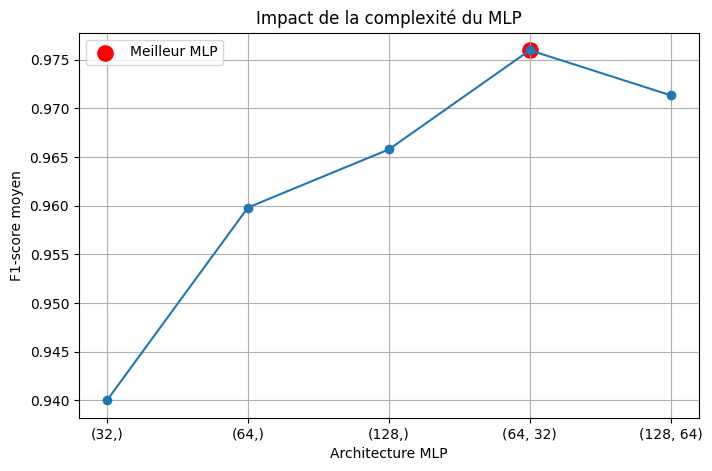

In [11]:
x_labels = [str(l) for l in hidden_layer_configs]
best_idx = np.argmax(mean_f1_scores)

plt.figure(figsize=(8,5))
plt.plot(x_labels, mean_f1_scores, marker="o")
plt.scatter(
    x_labels[best_idx],
    mean_f1_scores[best_idx],
    color="red",
    s=120,
    label="Meilleur MLP"
)
plt.xlabel("Architecture MLP")
plt.ylabel("F1-score moyen")
plt.title("Impact de la complexité du MLP")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
best_layers = hidden_layer_configs[best_idx]

best_mlp_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=best_layers,
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=42,
        early_stopping=True
    ))
])

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

scores = cross_validate(
    best_mlp_pipeline,
    X, y,
    cv=skf,
    scoring=scoring,
    n_jobs=-1
)

print("\nMLP – Scores moyens\n")
for m in scoring:
    print(f"{m:<10}: {scores['test_' + m].mean():.3f}")



MLP – Scores moyens

accuracy  : 0.966
precision : 0.977
recall    : 0.975
f1        : 0.976
roc_auc   : 0.995


In [13]:
# Entraînement final du meilleur MLP pour analyser la loss
final_mlp_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=best_layers,
        activation="relu",
        solver="adam",
        max_iter=300,
        random_state=42,
        early_stopping=True
    ))
])

final_mlp_pipeline.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('mlp', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

In [14]:
mlp_model = final_mlp_pipeline.named_steps["mlp"]

loss_curve = mlp_model.loss_curve_
final_loss = loss_curve[-1]

print(f"Loss finale à la fin de l'entraînement : {final_loss:.4f}")


Loss finale à la fin de l'entraînement : 0.0265


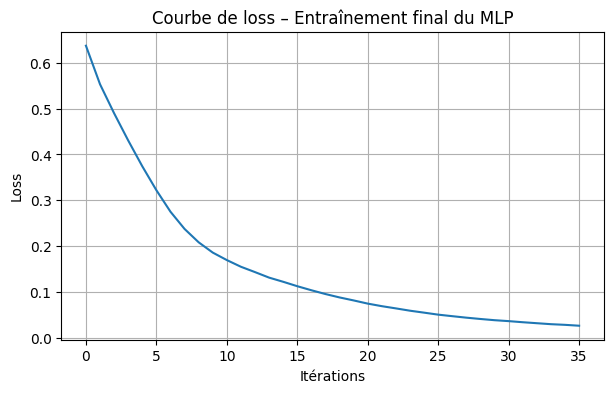

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(loss_curve)
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.title("Courbe de loss – Entraînement final du MLP")
plt.grid(True)
plt.show()
